# Using the Simpy library to model simple asynchronous CMOS circuits

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy.random
import simpy
from PIL import Image
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['text.usetex'] = True

## Inverters

An ideal logic inverter is bistable, taking on a value of either logical 0 or logical 1. However, outside of simulations, inverters have certain limitations. While noise can be minimized, some amount is inevitable. There are also limitations on how fast the inverter can change its output state. This model attempts to account for such limitations. It makes several simplifying assumptions: time is measured in discrete steps and the behavior of the model is linear (except for noise) within its maximum and minimum operating range.

There are also allowances for connecting inverters via nonlinear coupling elements resembling ideal diodes, explained later.

In [64]:
class Inv:
    def __init__(self, 
                 env, 
                 delay=1e-2, 
                 noise=1e-4, 
                 jitter=1e-4, 
                 inc=1e-2,
                 beta=.47,
                 log=[]
                ):
        self.env = env
        self.state = noise * np.random.randn()
        self.delay = delay
        self.jitter = jitter
        self.inc = inc
        self.noise = noise
        self.beta = beta
        self.connections = []
        self.rectify_in = []
        self.rectify_out = []
        self.log = log
        self.proc = env.process(self.trig())

    def time(self):
        return self.delay + self.jitter * np.random.randn()

    def get(self):
        return self.state

    def trig(self):
        while 1:
            self.log.append(self.state)
            yield env.timeout(self.time())
            
            input = 0
            load = 0
            for c in self.connections:
                input += max(-1, min(1, c.get()))
            for c in self.rectify_in:
                input += self.beta * max(0, min(1, c.get()))
            for c in self.rectify_out:
                load += self.beta * max(0, min(1, self.state - c.get()))
            self.state -= self.inc * input
            self.state += self.inc * load
            self.state += self.noise * np.random.randn()
            self.state = max(-1, self.state)
            self.state = min(1, self.state)

    # These represent INCOMING connections
    def connect(self, other):
        self.connections.append(other)

    def connect_rectify(self, other):
        self.rectify_in.append(other)
        other.connect_rectify_out(self)

    def connect_rectify_out(self, other):
        self.rectify_out.append(other)

# Oscillators

This is a convenience class for creating ring oscillators of arbitrary sizes. Ring oscillators with an odd number of inverters should always display periodic behavior, with the phase relationships between each inverter remaining equal.

In [3]:
class Osc:
    def __init__(self, env, delay, size=3, inc=1e-2):
        self.env = env
        self.size = size
        self.logs = [[] for _ in range(size)]
        self.invs = [Inv(env=self.env, delay=delay, inc=inc, log=self.logs[i]) for i in range(size)]
        for i in range(size):
            self.invs[i].connect(self.invs[i-1])

## Simple 3-inverter oscillator

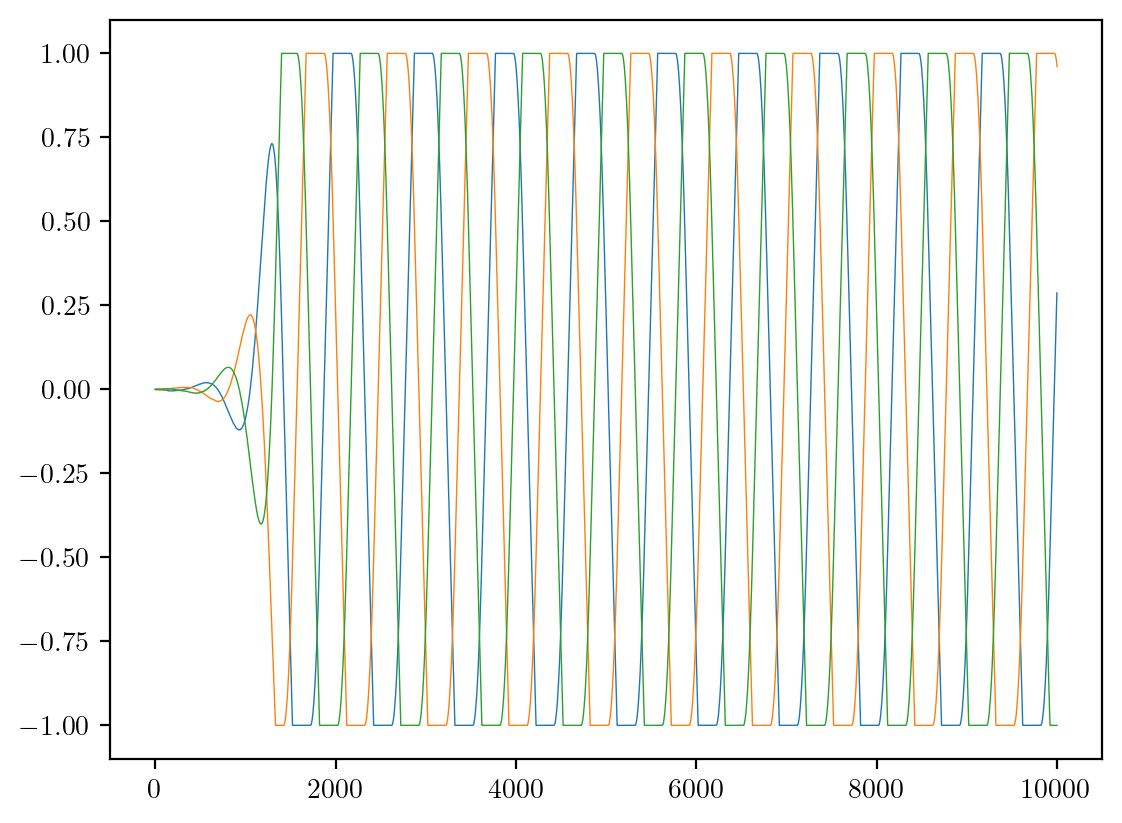

In [43]:
env = simpy.Environment()
osc = Osc(env, delay=1e-2)
env.run(until=100)
data = osc.logs
for d in data:
    plt.plot(d, lw=.5)
plt.show()

## Complex circuit emulation

The following circuit was found in the journal article, "Current-Starved Cross-Coupled CMOS Inverter Rings as Versatile Generators of Chaotic and Neural-Like Dynamics Over Multiple Frequency Decades".

"Each ring is coupled to the one or two having a higher number of stages, i.e., 3 <-> 5, 3 <-> 7 and 5 <-> 7, via a coupling cell consisting of a nonlinear block resembling a diode."

Nonlinear elements raise the potential for chaotic behavior. With a highly simplified implementation, I was able to observe aperiodic behavior with a beta value of 0.47.

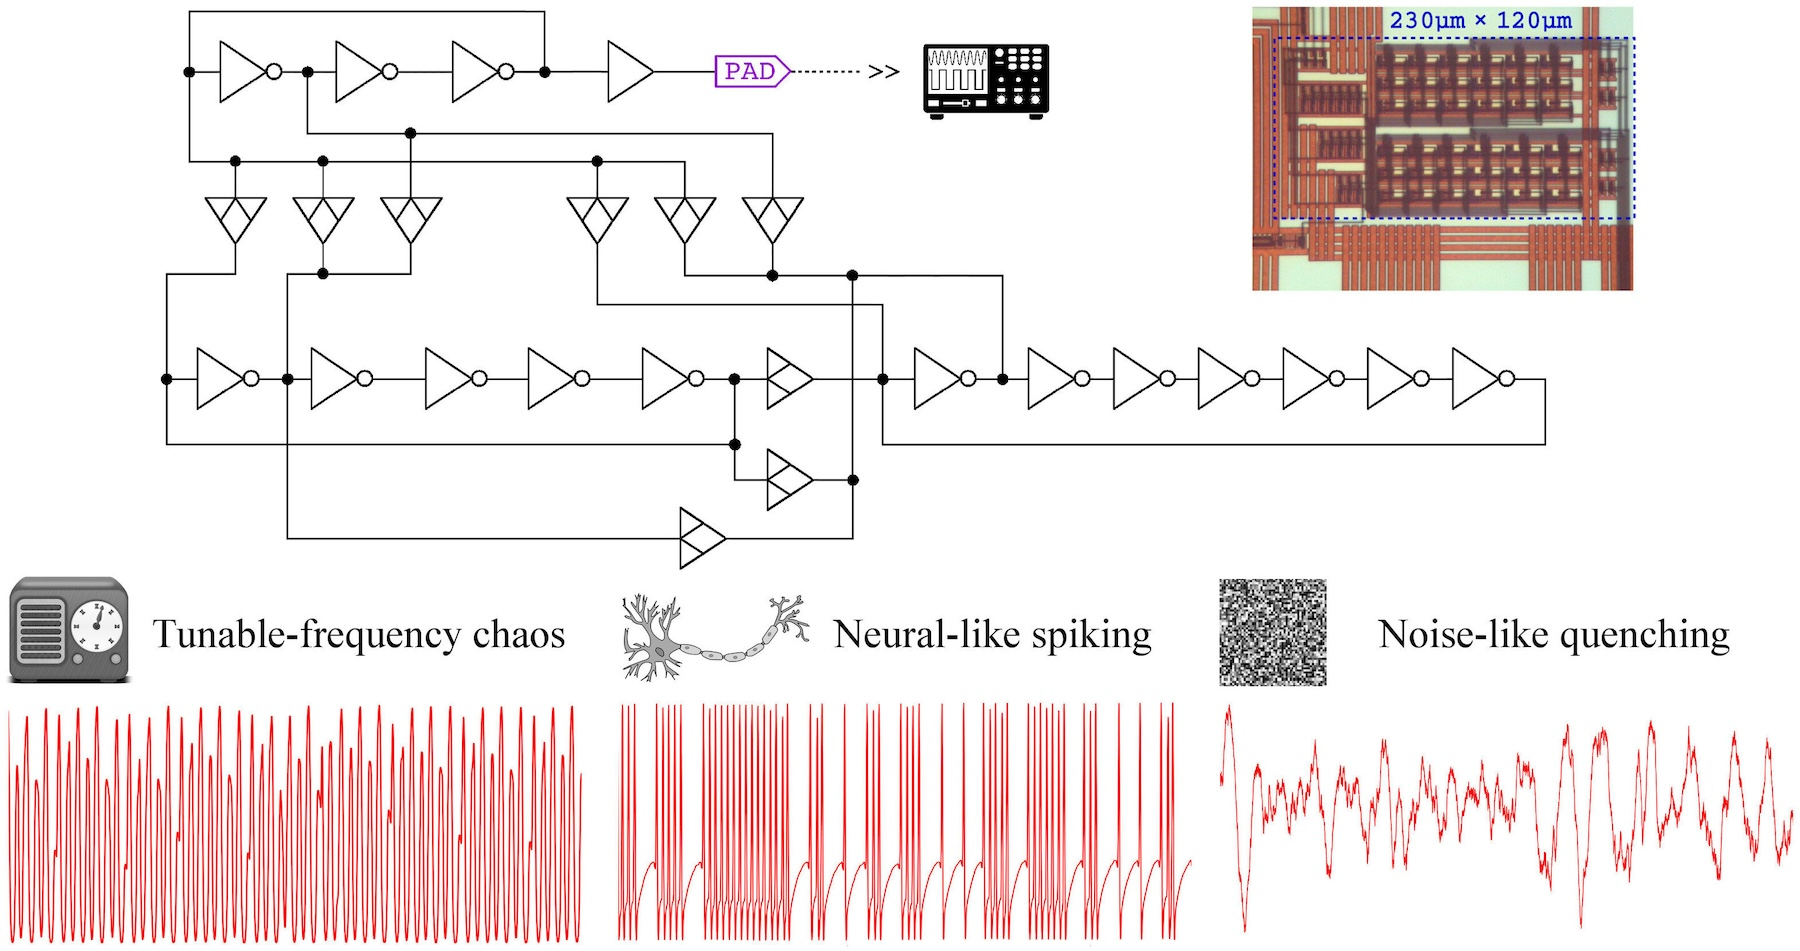

In [5]:
display(Image.open("tokyo_institute_chaotic_generator.jpeg"))

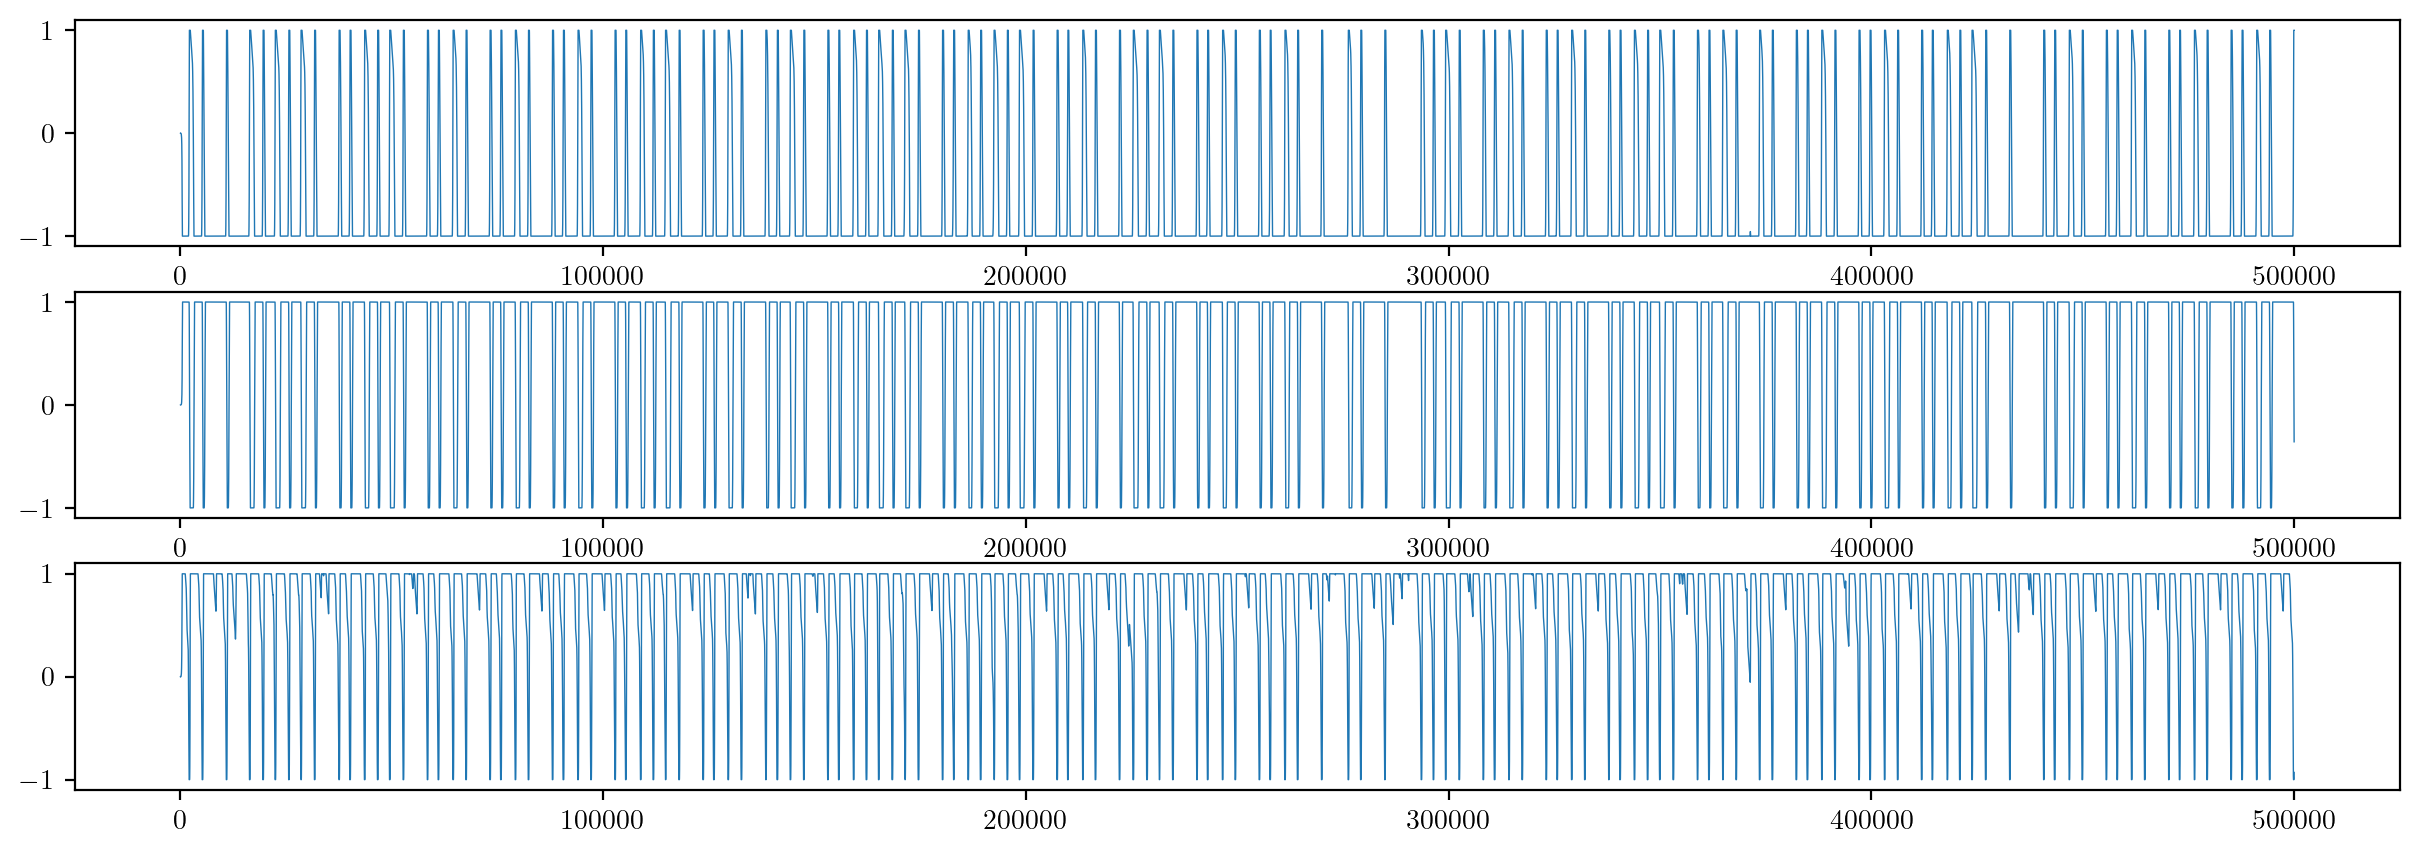

In [69]:
env = simpy.Environment()

osc3 = Osc(env, size=3, delay=1e-1)
osc5 = Osc(env, size=5, delay=1e-1)
osc7 = Osc(env, size=7, delay=1e-1)

osc5.invs[0].connect_rectify(osc3.invs[2])
osc5.invs[1].connect_rectify(osc3.invs[2])
osc5.invs[1].connect_rectify(osc3.invs[0])
osc7.invs[0].connect_rectify(osc3.invs[2])
osc7.invs[0].connect_rectify(osc5.invs[4])
osc7.invs[1].connect_rectify(osc3.invs[0])
osc7.invs[1].connect_rectify(osc3.invs[2])
osc7.invs[1].connect_rectify(osc5.invs[0])
osc7.invs[1].connect_rectify(osc5.invs[4])

env.run(until=50000)
data1 = osc3.logs
fig, ax = plt.subplots(len(data1), 1, figsize=(15,5))
for i, d in enumerate(data1):
    ax[i].plot(d, lw=.5)
plt.show()